<a href="https://colab.research.google.com/github/francescopatane96/Computer_aided_drug_discovery_kit/blob/main/9_ligandbased_pharmacophores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. Ligand-based pharmacophores

In [ ]:
pip install rdkit nglview

In [4]:
import collections
from collections import Counter
from pathlib import Path
import operator
import time
import math

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets, cluster

from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import (
    ChemicalFeatures,
    rdDistGeom,
    Draw,
    rdMolTransforms,
    AllChem,
)
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
import nglview as nv

In [41]:
from pathlib import Path

In [43]:
# Define paths
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [44]:
mol_files = sorted(Path(DATA).glob("*_lig.pdb"))
print([f.name for f in mol_files])

['5HG8_lig.pdb', '5UG8_lig.pdb', '5UG9_lig.pdb', '5UGC_lig.pdb']


In [45]:
# NBVAL_CHECK_OUTPUT
pdb_ids = [Path(file).stem.split("_")[0] for file in mol_files]
pdb_ids

['5HG8', '5UG8', '5UG9', '5UGC']

In [46]:
# NBVAL_CHECK_OUTPUT
molecules = []
for mol_file in mol_files:
    molecule = Chem.MolFromPDBFile(str(mol_file), removeHs=False)
    if molecule is None:
        print(mol_file, "Could not be read")
    else:
        Chem.SanitizeMol(molecule)
        print(Chem.MolToSmiles(molecule))
        molecules.append(molecule)
print(f"Number of molecules: {len(molecules)}")

CCC(O)NC1CCCC(OC2NC(NC3CNN(C)C3)NC3NCCC32)C1
CCC(O)NC1CN(C2NC(NC3CNN(C)C3)C3NCN(C(C)C)C3N2)CC1F
CCC(O)NC1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C(C)C)C3N2)CC1F
CCC(O)NC1CN(C2NC(NC3CN(C)NC3OC)C3NCN(C)C3N2)CC1F
Number of molecules: 4


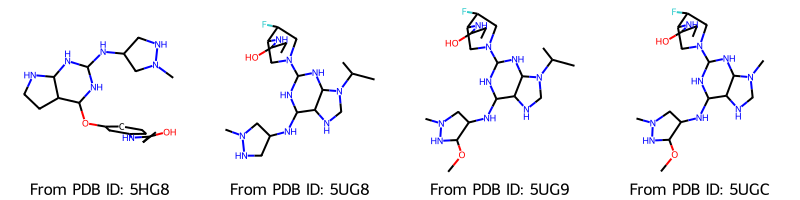

In [47]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

In [49]:
# Load SMILES for PDB ligand structures
ligands = pd.read_csv(HERE / "PDB_top_ligands.csv")

# Get SMILES in the same order as in pdb_ids
ligand_smiles = [
    ligands[ligands["@structureId"] == pdb_id]["smiles"].values[0] for pdb_id in pdb_ids
]

# Generate RDKit Mol object from SMILES
reference_molecules = [Chem.MolFromSmiles(smiles) for smiles in ligand_smiles]

# Assign bond orders to molecules based on SMILES patterns of reference molecules
molecules = [
    AllChem.AssignBondOrdersFromTemplate(reference_molecule, molecule)
    for reference_molecule, molecule in zip(reference_molecules, molecules)
]

[15:08:10] WARNING: More than one matching pattern found - picking one

[15:08:10] WARNING: More than one matching pattern found - picking one



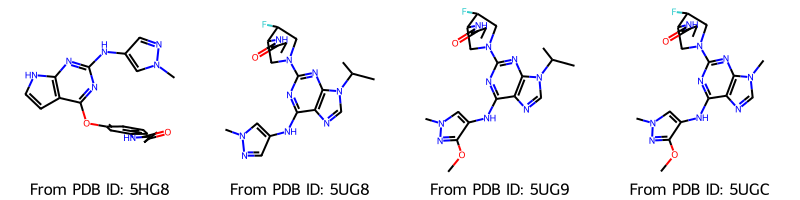

In [50]:
Draw.MolsToGridImage(
    molecules,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

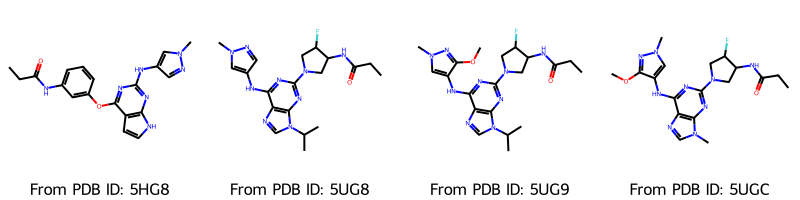

In [51]:
molecules_2d = []
for molecule in molecules:
    tmp = Chem.Mol(molecule)
    AllChem.Compute2DCoords(tmp)
    molecules_2d.append(tmp)
Draw.MolsToGridImage(
    molecules_2d,
    molsPerRow=4,
    legends=[f"From PDB ID: {pdb_id}" for pdb_id in pdb_ids],
)

In [52]:
def show_ligands(molecules):
    """Generate a view of the ligand molecules.

    Parameters
    -----------
    molecules: list of rdkit.Chem.rdchem.Mol

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = nv.NGLWidget()
    for molecule in molecules:
        component = view.add_component(molecule)
        time.sleep(0.1)
        component.clear()
        component.add_ball_and_stick(multipleBond=True)
    return view

In [54]:
from google.colab import output
output.enable_custom_widget_manager()

In [55]:
view = show_ligands(molecules)
view

NGLWidget()

In [56]:
view.render_image(trim=True, factor=2, transparent=True);

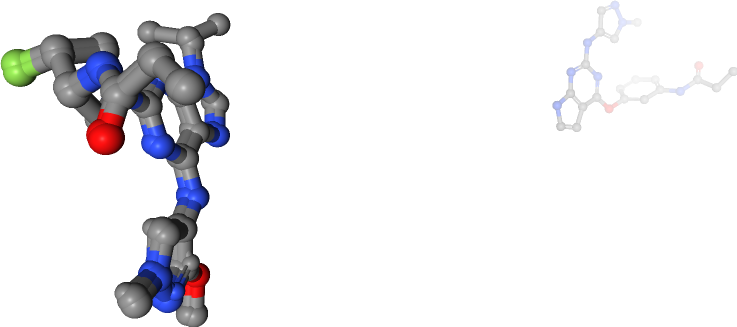

In [58]:
view._display_image()

In [60]:
feature_factory = AllChem.BuildFeatureFactory(str(Path(RDConfig.RDDataDir) / "BaseFeatures.fdef"))

In [61]:
list(feature_factory.GetFeatureDefs().keys())

['Donor.SingleAtomDonor',
 'Acceptor.SingleAtomAcceptor',
 'NegIonizable.AcidicGroup',
 'PosIonizable.BasicGroup',
 'PosIonizable.PosN',
 'PosIonizable.Imidazole',
 'PosIonizable.Guanidine',
 'ZnBinder.ZnBinder1',
 'ZnBinder.ZnBinder2',
 'ZnBinder.ZnBinder3',
 'ZnBinder.ZnBinder4',
 'ZnBinder.ZnBinder5',
 'ZnBinder.ZnBinder6',
 'Aromatic.Arom4',
 'Aromatic.Arom5',
 'Aromatic.Arom6',
 'Aromatic.Arom7',
 'Aromatic.Arom8',
 'Hydrophobe.ThreeWayAttach',
 'Hydrophobe.ChainTwoWayAttach',
 'LumpedHydrophobe.Nitro2',
 'LumpedHydrophobe.RH6_6',
 'LumpedHydrophobe.RH5_5',
 'LumpedHydrophobe.RH4_4',
 'LumpedHydrophobe.RH3_3',
 'LumpedHydrophobe.tButyl',
 'LumpedHydrophobe.iPropyl']

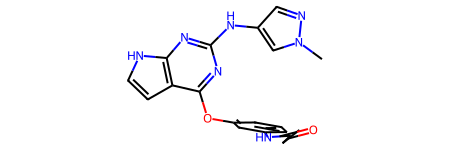

In [62]:
example_molecule = molecules[0]
example_molecule

In [63]:
# NBVAL_CHECK_OUTPUT
features = feature_factory.GetFeaturesForMol(example_molecule)
print(f"Number of features found: {len(features)}")

Number of features found: 16


In [64]:
# NBVAL_CHECK_OUTPUT
features[0].GetFamily()

'Donor'

In [65]:
# NBVAL_CHECK_OUTPUT
feature_frequency = collections.Counter(sorted([feature.GetFamily() for feature in features]))
feature_frequency

Counter({'Acceptor': 5,
         'Aromatic': 4,
         'Donor': 4,
         'Hydrophobe': 2,
         'LumpedHydrophobe': 1})

In [66]:
molecule_feature_frequencies = []
for molecule in molecules:
    features = [feature.GetFamily() for feature in feature_factory.GetFeaturesForMol(molecule)]
    feature_frequency = collections.Counter(features)
    molecule_feature_frequencies.append(feature_frequency)

feature_frequencies_df = (
    pd.DataFrame(
        molecule_feature_frequencies,
        index=[f"Mol{i}" for i, _ in enumerate(molecules, 1)],
    )
    .fillna(0)
    .astype(int)
)
feature_frequencies_df.transpose()

,Mol1,Mol2,Mol3,Mol4
Donor,4,2,2,2
Acceptor,5,6,7,7
Aromatic,4,3,3,3
Hydrophobe,2,1,1,1
LumpedHydrophobe,1,1,1,0
PosIonizable,0,1,1,1


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Mol1'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['Mol2'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['Mol3'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['Mol4'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['Mol1'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['Mol2'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['Mol3'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['Mol4'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['Mol1', 'Mol2'], ['Mol2', 'Mol3'], ['Mol3', 'Mol4']]], **{})
chart

In [67]:
acceptors = []
donors = []
hydrophobics = []

for molecule in molecules:
    acceptors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Acceptor"))
    donors.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Donor"))
    hydrophobics.append(feature_factory.GetFeaturesForMol(molecule, includeOnly="Hydrophobe"))

features = {
    "donors": donors,
    "acceptors": acceptors,
    "hydrophobics": hydrophobics,
}

In [68]:
feature_colors = {
    "donors": (0, 0.9, 0),  # Green
    "acceptors": (0.9, 0, 0),  # Red
    "hydrophobics": (1, 0.9, 0),  # Yellow
}

In [69]:
def visualize_features(
    molecules,
    features,
    feature_type="features",
    color="yellow",
    sphere_radius=0.5,
):
    """Generate a view of the molecules highlighting the specified feature type.

    Parameters
    -----------
    molecules: list of rdkit.Chem.rdchem.Mol
        molecules to be visualized
    features: list of tuples of rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature
        extracted features from molecules chosen to be highlighted
    feature_type: string, optional
        name of the feature to be highlighted
    color: string, optional
        color used to display the highlighted features
    sphere_radius: float, optional
        display size of the highlighted features

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    print(f"Number of {feature_type} in all ligands: {sum([len(i) for i in features])}")
    view = show_ligands(molecules)
    for i, feature_set in enumerate(features, 1):
        for feature in feature_set:
            loc = list(feature.GetPos())
            label = f"{feature_type}_{i}"
            view.shape.add_sphere(loc, color, sphere_radius, label)
    return view

In [70]:
feature_type = "donors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of donors in all ligands: 10


NGLWidget()

In [71]:
view.render_image(trim=True, factor=2, transparent=True);

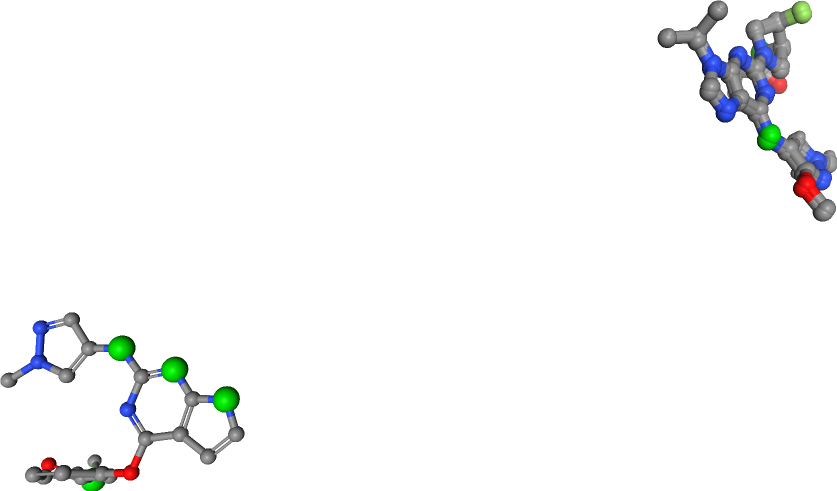

In [73]:
view._display_image()

In [74]:
feature_type = "acceptors"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of acceptors in all ligands: 25


NGLWidget()

In [76]:
view.render_image(trim=True, factor=2, transparent=True);

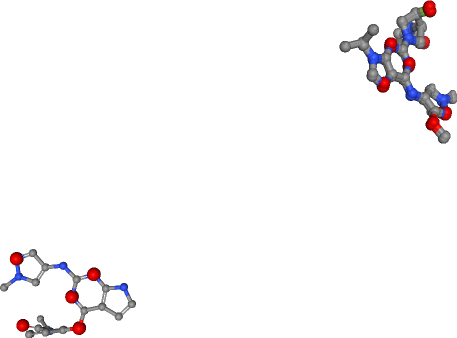

In [77]:
view._display_image()

In [78]:
feature_type = "hydrophobics"
view = visualize_features(
    molecules,
    features[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of hydrophobics in all ligands: 5


NGLWidget()

In [79]:
view.render_image(trim=True, factor=2, transparent=True);

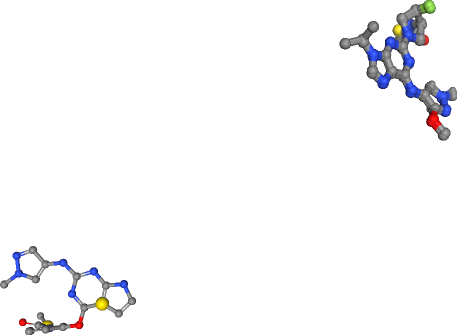

In [80]:
view._display_image()

In [81]:
features_coord = {
    "donors": [list(item.GetPos()) for sublist in features["donors"] for item in sublist],
    "acceptors": [list(item.GetPos()) for sublist in features["acceptors"] for item in sublist],
    "hydrophobics": [
        list(item.GetPos()) for sublist in features["hydrophobics"] for item in sublist
    ],
}

In [82]:
features_coord["acceptors"]

[[12.373, -3.314, -33.274],
 [10.7, -1.613, -33.576],
 [11.856, -5.658, -33.171],
 [17.138, -6.238, -29.068],
 [16.557, -0.53, -32.978],
 [-13.84, 14.773, -27.216],
 [-12.179, 16.227, -28.145],
 [-11.416, 12.929, -29.356],
 [-16.767, 10.824, -25.959],
 [-15.469, 19.365, -27.288],
 [-16.073, 17.221, -22.619],
 [-13.863, 14.66, -27.134],
 [-12.175, 16.118, -27.994],
 [-11.411, 12.856, -29.266],
 [-17.026, 10.809, -26.396],
 [-15.601, 9.901, -28.086],
 [-15.445, 19.229, -27.215],
 [-16.044, 17.165, -22.506],
 [-13.847, 14.509, -26.997],
 [-12.191, 15.981, -27.915],
 [-11.39, 12.686, -29.117],
 [-17.004, 10.64, -26.316],
 [-15.524, 9.732, -27.955],
 [-15.566, 19.015, -27.149],
 [-16.11, 17.099, -22.372]]

In [83]:
kq = 7

In [84]:
min_cluster_size = int(len(molecules) * 0.75)
top_cluster_number = 4

In [85]:
def clustering(feature_coord, kq):
    """
    Compute the k-means clustering of input feature coordinates.

    Parameters
    -----------
    feature_coord: list
        feature coordinates extracted from the features of a set of molecules
    kq: int
        Quotient used when calculating number of features k

    Returns
    ----------
    sklearn.cluster._kmeans.KMeans
    """
    # Define parameter k as feature number divided by "k quotient"
    k = math.ceil(len(feature_coord) / kq)
    # Tailor-made adaption of k for hydrophobics in for the example in this talktorial
    k = 2 if k == 1 else k
    print(f"Clustering: \nVariable k in k-means: {k} of {len(feature_coord)} points\n")

    # Initialize k-means and compute clustering
    k_means = cluster.KMeans(n_clusters=k, n_init=10)
    k_means.fit(feature_coord)

    return k_means

In [86]:
def get_clusters(k_means, min_cluster_size, top_cluster_number):
    """
    Select clusters from a k-means clustering and returns the indices of the selected clusters.
    The selection is based on cluster size. The largest clusters are chosen.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    min_cluster_size: int
        minimum size needed for a cluster to be viable for selection
    top_cluster_number: int
        number of clusters to be selected

    Returns
    ----------
    list of int
        indices of selected clusters
    """

    # Sort clusters by size and only show largest
    feature_labels = k_means.labels_

    feature_labels_count = Counter(feature_labels)

    feature_labels_count = sorted(
        feature_labels_count.items(), key=operator.itemgetter(1), reverse=True
    )
    print(f"Clusters sorted by size: \n{feature_labels_count}\n")

    # Get number of the largest clusters, which are larger then the threshold (selected clusters)
    cluster_indices_sel = []

    for cluster_index, cluster_size in feature_labels_count:
        if cluster_size >= min_cluster_size and top_cluster_number > 0:
            cluster_indices_sel.append(cluster_index)
            top_cluster_number -= 1

    print(f"Cluster indices of selected clusters: \n{cluster_indices_sel}\n")

    return cluster_indices_sel

In [87]:
k_means = {
    "donors": clustering(features_coord["donors"], kq),
    "acceptors": clustering(features_coord["acceptors"], kq),
    "hydrophobics": clustering(features_coord["hydrophobics"], kq),
}

Clustering: 
Variable k in k-means: 2 of 10 points

Clustering: 
Variable k in k-means: 4 of 25 points

Clustering: 
Variable k in k-means: 2 of 5 points



In [88]:
print("Hydrogen bond donors\n")
cluster_indices_sel_donors = get_clusters(k_means["donors"], min_cluster_size, top_cluster_number)

Hydrogen bond donors

Clusters sorted by size: 
[(0, 6), (1, 4)]

Cluster indices of selected clusters: 
[0, 1]



In [89]:
print("Hydrogen bond acceptors\n")
cluster_indices_sel_acceptors = get_clusters(
    k_means["acceptors"], min_cluster_size, top_cluster_number
)

Hydrogen bond acceptors

Clusters sorted by size: 
[(3, 9), (2, 6), (1, 5), (0, 5)]

Cluster indices of selected clusters: 
[3, 2, 1, 0]



In [90]:
print("Hydrophobic contacts\n")
cluster_indices_sel_hydrophobic = get_clusters(
    k_means["hydrophobics"], min_cluster_size, top_cluster_number
)

Hydrophobic contacts

Clusters sorted by size: 
[(0, 3), (1, 2)]

Cluster indices of selected clusters: 
[0]



In [91]:
cluster_indices_sel = {
    "donors": cluster_indices_sel_donors,
    "acceptors": cluster_indices_sel_acceptors,
    "hydrophobics": cluster_indices_sel_hydrophobic,
}

In [92]:
def get_selected_cluster_center_coords(k_means, cluster_indices_sel):
    """Retrieve cluster center coordinates for selected clusters.
    The selected clusters are defined by their indices.

    Parameters
    -----------
    k_means: sklearn.cluster._kmeans.KMeans
        k-means clustering of feature coordinates
    cluster_indices_sel: list of int
        indices of the chosen clusters

    Returns
    ----------
    two-dimensional list of floats
        cluster center coordinates
    """
    cluster_centers = k_means.cluster_centers_

    # Cast to list and then to pandas Series (for element selection by indices)
    cluster_centers = pd.Series(cluster_centers.tolist())

    # Select cluster centers by indices of selected clusters
    cluster_centers_sel = cluster_centers[cluster_indices_sel]

    return list(cluster_centers_sel)

In [93]:
cluster_centers_sel = {
    "donors": get_selected_cluster_center_coords(k_means["donors"], cluster_indices_sel["donors"]),
    "acceptors": get_selected_cluster_center_coords(
        k_means["acceptors"], cluster_indices_sel["acceptors"]
    ),
    "hydrophobics": get_selected_cluster_center_coords(
        k_means["hydrophobics"], cluster_indices_sel["hydrophobics"]
    ),
}

In [94]:
cluster_centers_sel["acceptors"]

[[-12.479111111111111, 14.526555555555555, -28.126666666666665],
 [-15.7845, 18.182333333333332, -24.858166666666666],
 [13.724800000000002, -3.4705999999999992, -32.4134],
 [-16.3844, 10.3812, -26.9424]]

In [95]:
def visualize_clusters(
    molecules,
    features,
    clusters,
    feature_type="features",
    color="yellow",
    feature_radius=0.5,
    cluster_radius=1,
):
    """Visualize the cluster centers.

    Parameters
    -----------
     molecules: list of rdkit.Chem.rdchem.Mol
        molecules to be visualized
    features: list of tuples of rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature
        extracted features from molecules chosen to be highlighted
    clusters: Two-dimensional list of floats
        cluster center coordinates
    feature_type: string, optional
        feature type being visualized
    color: string, optional
        color used for rendering the features and cluster centers
    feature_radius: float, optional
        rendering size of the features
    cluster_radius: float, optional
        rendering size of the cluster centers

    Returns
    ----------
    nglview.widget.NGLWidget
    """
    view = visualize_features(
        molecules,
        features,
        feature_type,
        color=color,
        sphere_radius=feature_radius,
    )
    for i, center in enumerate(clusters, 1):
        view.shape.add_sphere(list(center), color, cluster_radius, f"cluster_{feature_type}_{i}")
    return view

In [96]:
feature_type = "donors"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of donors in all ligands: 10


NGLWidget()

In [97]:
view.render_image(trim=True, factor=2, transparent=True);

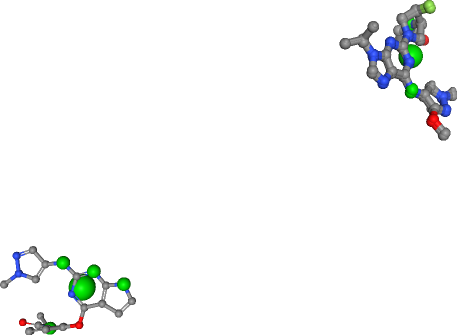

In [98]:
view._display_image()

In [99]:
feature_type = "acceptors"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of acceptors in all ligands: 25


NGLWidget()

In [103]:
view.render_image(trim=True, factor=2, transparent=True);

In [104]:
view._display_image()

In [105]:
feature_type = "hydrophobics"
view = visualize_clusters(
    molecules,
    features[feature_type],
    cluster_centers_sel[feature_type],
    feature_type,
    feature_colors[feature_type],
)
view

Number of hydrophobics in all ligands: 5


NGLWidget()

In [106]:
view.render_image(trim=True, factor=2, transparent=True);

In [ ]:
view._display_image()